In [1]:
!pip install datasets evaluate transformers[sentencepiece]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
#zstandard是一个高效的数据压缩库
!pip install zstandard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 35.1 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset

# This takes a few minutes to run, so go grab a tea or coffee while you wait :)
data_files = "https://huggingface.co/datasets/qualis2006/PUBMED_title_abstracts_2020_baseline/resolve/main/PUBMED_title_abstracts_2020_baseline.jsonl.zst"
pubmed_dataset = load_dataset("json", data_files=data_files, split="train")
pubmed_dataset

(…)_title_abstracts_2020_baseline.jsonl.zst:   0%|          | 0.00/7.98G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/49 [00:00<?, ?it/s]

Dataset({
    features: ['meta', 'text'],
    num_rows: 17722096
})

In [5]:
#查看第一个数据
pubmed_dataset[0]

{'meta': {'pmid': 1673585, 'language': 'eng'},
 'text': 'Cardiac beta-adrenoceptor regulation and the effects of partial agonism.\nThe in vivo effects of xamoterol on the regulation of rat cardiac beta adrenoceptors were investigated. Rats were implanted subcutaneously with osmotic minipumps and exposed to the following treatment regimens: (1) subcutaneous infusion of saline (control), isoprenaline or xamoterol for 6 days, (2) subcutaneous infusion of isoprenaline with co-administration of xamoterol for various periods up to 96 hours, and (3) subcutaneous infusion of xamoterol for up to 96 hours after previous treatment with isoprenaline for 72 hours. Xamoterol did not induce beta-adrenoceptor down-regulation after short-term (72-hour) or long-term (6-day) infusions. When coadministered with isoprenaline xamoterol did not affect the rate or extent of down-regulation induced by isoprenaline alone. In addition, recovery of beta adrenoceptors down-regulated by isoprenaline treatment was n

In [6]:
#psutil库提供方便的方法来获取系统和进程信息：如CPU、内存、磁盘、网络等资源使用情况
!pip install psutil

In [7]:
#rss/(1024*1024): Process.memory_info is expressed in Bytes, so convert to MegaBytes
#.memory_info()获取当前进程的内存使用信息
#rss(resident set size)是当前进程实际占用的物理内存
# ;.2f格式化输出，保留两位小数便于查看

import psutil

print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 749.15 MB


In [8]:
print(f"Number of files in dataset : {pubmed_dataset.dataset_size}")
size_gb = pubmed_dataset.dataset_size / (1024**3)
print(f"Dataset size (cache file) : {size_gb:.2f} GB")

Number of files in dataset : 24453015916
Dataset size (cache file) : 22.77 GB


从这里我们可以看到，即使文件有22.77GB大，我们加载到RAM的远远小于22.77GB。

如果你熟悉 Pandas，可能会对这个结果感到惊讶，因为 Wes Kinney 提出的著名经验法则是，你通常需要 5 到 10 倍于数据集大小的内存。

那么，🤗 Datasets 是如何解决内存管理问题的呢？

Datasets 将每个数据集视为一个内存映射文件（memory-mapped file），这提供了一个将 RAM 与文件系统存储之间的映射关系，使得库可以在不需要将整个数据集完全加载到内存中的情况下，访问和操作数据集中的元素。

此外，内存映射文件支持在多个进程之间共享，使得像 Dataset.map() 这样的操作能够并行执行，而无需复制或移动数据。这些功能是通过 Apache Arrow 内存格式和 pyarrow 库实现的，从而大幅提高了数据加载和处理速度。

接下来，我们可以通过一个小的速度测试来演示这一点，遍历 PubMed 摘要数据集中的所有元素。

In [9]:
#timeit库可以测量执行某段代码的时间
import timeit

code_snippet = """batch_size = 1000

for idx in range(0, len(pubmed_dataset), batch_size):
    _ = pubmed_dataset[idx:idx + batch_size]
"""

time = timeit.timeit(stmt=code_snippet, number=1, globals=globals()) #number=1表示执行一次代码片段
print(
    f"Iterated over {len(pubmed_dataset)} examples (about {size_gb:.1f} GB) in "
    f"{time:.1f}s, i.e. {size_gb/time:.3f} GB/s"
)

Iterated over 17722096 examples (about 22.8 GB) in 340.0s, i.e. 0.067 GB/s


In [10]:
#使用数据流模型，意味着数据集不会一次性全部加载到内存中，而是按需逐个批次加载数据。
#这样可以有效节省内存，特别适用于处理大型数据集
pubmed_dataset_streamed = load_dataset(
    "json", data_files=data_files, split="train", streaming=True
)

streaming=True返回的对象不是我们在本章其他地方遇到的熟悉的Dataset，而是IterableDataset。

顾名思义，要访问IterableDataset，我们需要对其进行迭代。我们可以按如下方式访问数据集的第一个元素。

In [11]:
#iter(pubmed_dataset_streamed)将流式数据集pubmed_dataset_streamed转换为一个迭代器，使其可以逐个元素地进行访问。
#next()获取迭代器中的下一个元素。
#因为数据集是以流式方式加载的，每次调用next()都会从数据集中获取一个新的数据项
next(iter(pubmed_dataset_streamed))

{'meta': {'pmid': 1673585, 'language': 'eng'},
 'text': 'Cardiac beta-adrenoceptor regulation and the effects of partial agonism.\nThe in vivo effects of xamoterol on the regulation of rat cardiac beta adrenoceptors were investigated. Rats were implanted subcutaneously with osmotic minipumps and exposed to the following treatment regimens: (1) subcutaneous infusion of saline (control), isoprenaline or xamoterol for 6 days, (2) subcutaneous infusion of isoprenaline with co-administration of xamoterol for various periods up to 96 hours, and (3) subcutaneous infusion of xamoterol for up to 96 hours after previous treatment with isoprenaline for 72 hours. Xamoterol did not induce beta-adrenoceptor down-regulation after short-term (72-hour) or long-term (6-day) infusions. When coadministered with isoprenaline xamoterol did not affect the rate or extent of down-regulation induced by isoprenaline alone. In addition, recovery of beta adrenoceptors down-regulated by isoprenaline treatment was n

In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenized_dataset = pubmed_dataset_streamed.map(lambda x: tokenizer(x["text"]))
next(iter(tokenized_dataset))

{'meta': {'pmid': 1673585, 'language': 'eng'},
 'text': 'Cardiac beta-adrenoceptor regulation and the effects of partial agonism.\nThe in vivo effects of xamoterol on the regulation of rat cardiac beta adrenoceptors were investigated. Rats were implanted subcutaneously with osmotic minipumps and exposed to the following treatment regimens: (1) subcutaneous infusion of saline (control), isoprenaline or xamoterol for 6 days, (2) subcutaneous infusion of isoprenaline with co-administration of xamoterol for various periods up to 96 hours, and (3) subcutaneous infusion of xamoterol for up to 96 hours after previous treatment with isoprenaline for 72 hours. Xamoterol did not induce beta-adrenoceptor down-regulation after short-term (72-hour) or long-term (6-day) infusions. When coadministered with isoprenaline xamoterol did not affect the rate or extent of down-regulation induced by isoprenaline alone. In addition, recovery of beta adrenoceptors down-regulated by isoprenaline treatment was n

In [15]:
#buffer_size=10000：指定缓冲区的大小，表示只有在缓冲区满时，才会对数据进行随机打乱
#指定缓冲区可以提高数据打乱的效率
shuffled_dataset = pubmed_dataset_streamed.shuffle(buffer_size=10000, seed=42)
next(iter(shuffled_dataset))

{'meta': {'pmid': 1675166, 'language': 'ita'},
 'text': '[Benzodiazepine withdrawal syndrome].\nBenzodiazepines (BDZ) are widely prescribed in clinical practice for many pathological conditions, because of their anxiolytic, sedative, myorelaxant and anticonvulsant properties. The effectiveness, specificity and rapidity of action, the few side effects and the virtual absence of toxicity, have contributed to the widespread use of these compounds. In the last decade, however, the attitude towards BDZ has greatly changed, due to growing awareness and concern about dependence liability, withdrawal phenomena, and long-term side effects. Withdrawal symptoms have been singled out and specified in the contest of a well-defined syndrome with foreseeable onset, duration and remission. Psychic and physical symptoms and disorders of sensory perception can be observed. These manifestations can be suppressed by resuming treatment. The symptomatic and developmental aspects of BDZ withdrawal syndrome a

In [16]:
#取前五个数据项看看，并将其转换为一个列表
dataset_head = pubmed_dataset_streamed.take(5)
list(dataset_head)

[{'meta': {'pmid': 1673585, 'language': 'eng'},
  'text': 'Cardiac beta-adrenoceptor regulation and the effects of partial agonism.\nThe in vivo effects of xamoterol on the regulation of rat cardiac beta adrenoceptors were investigated. Rats were implanted subcutaneously with osmotic minipumps and exposed to the following treatment regimens: (1) subcutaneous infusion of saline (control), isoprenaline or xamoterol for 6 days, (2) subcutaneous infusion of isoprenaline with co-administration of xamoterol for various periods up to 96 hours, and (3) subcutaneous infusion of xamoterol for up to 96 hours after previous treatment with isoprenaline for 72 hours. Xamoterol did not induce beta-adrenoceptor down-regulation after short-term (72-hour) or long-term (6-day) infusions. When coadministered with isoprenaline xamoterol did not affect the rate or extent of down-regulation induced by isoprenaline alone. In addition, recovery of beta adrenoceptors down-regulated by isoprenaline treatment was

In [17]:
#Skip the first 1000 examples and include the rest in the training set
train_dataset = shuffled_dataset.skip(1000)
#Take the first 1000 examples for the validation set
validation_dataset = shuffled_dataset.take(1000)

In [ ]:
law_dataset_streamed = load_dataset(
    "json",
    data_files="https://the-eye.eu/public/AI/pile_preliminary_components/FreeLaw_Opinions.jsonl.zst",
    split="train",
    streaming=True,
)
next(iter(law_dataset_streamed))

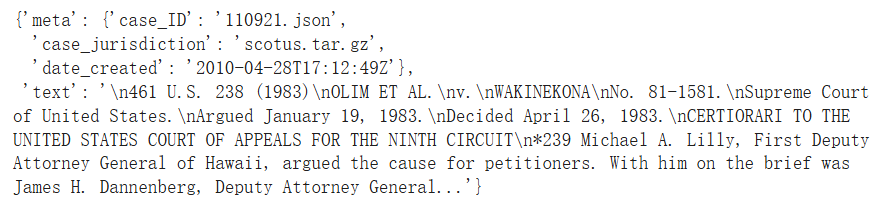

In [ ]:
"""
这段代码通过 interleave_datasets 将 pubmed_dataset_streamed 和 law_dataset_streamed 两个流式数据集交替合并，
并通过 islice 提取前 2 个样本。
"""

from itertools import islice
from datasets import interleave_datasets

combined_dataset = interleave_datasets([pubmed_dataset_streamed, law_dataset_streamed])
list(islice(combined_dataset, 2))

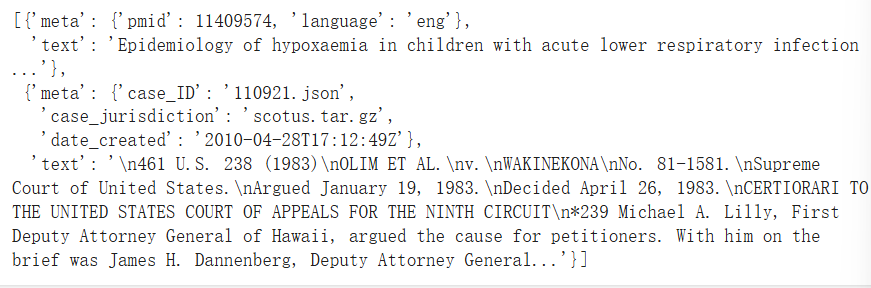